In [ ]:
!pip install nltk


import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
with open('percy_jackson.txt', 'r', encoding='utf-8') as file:
    percy_text = file.read()
print(f"Texto cargado. Primeros 500 caracteres:\n{percy_text[:500]}")
print(f"Longitud total del texto: {len(percy_text)} caracteres")

Texto cargado. Primeros 500 caracteres:
Sinopsis:

En Percy Jackson y el ladrón del rayo, un joven chico descubre que es
descendiente de un dios griego, y tendrá que prepararse para una batalla épica
entre los dioses.

                                CREDITOS A

                                 Purple Rose
                               Alishea Dreams

                       SUS MÁGNIFIC@S USUARI@S
                                            INDICE

1. Accidentalmente vaporice a mi profesor de álgebra .............. Pág. 3
2. Tres an
Longitud total del texto: 525454 caracteres


In [ ]:
tokens = word_tokenize(percy_text_lower)
print(f"\nNúmero total de tokens: {len(tokens)}")
print(f"Primeros 20 tokens:\n{tokens[:20]}")


Número total de tokens: 110261
Primeros 20 tokens:
['sinopsis', ':', 'en', 'percy', 'jackson', 'y', 'el', 'ladrón', 'del', 'rayo', ',', 'un', 'joven', 'chico', 'descubre', 'que', 'es', 'descendiente', 'de', 'un']


In [ ]:
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('spanish'))
punctuation_chars = set(string.punctuation)



filtered_tokens = []
for word in tokens:

    cleaned_word = ''.join(char for char in word if char not in punctuation_chars)
    cleaned_word = cleaned_word.lower()
    if cleaned_word and cleaned_word.isalpha():
        if cleaned_word not in stop_words:
            filtered_tokens.append(cleaned_word)

print(f"\n--- Después de eliminar puntuación, caracteres no alfabéticos y stop words ---")
print(f"Número de tokens después de preprocesamiento: {len(filtered_tokens)}")
print(f"Primeros 20 tokens filtrados:\n{filtered_tokens[:20]}")


--- Después de eliminar puntuación, caracteres no alfabéticos y stop words ---
Número de tokens después de preprocesamiento: 45692
Primeros 20 tokens filtrados:
['sinopsis', 'percy', 'jackson', 'ladrón', 'rayo', 'joven', 'chico', 'descubre', 'descendiente', 'dios', 'griego', 'prepararse', 'batalla', 'épica', 'dioses', 'creditos', 'purple', 'rose', 'alishea', 'dreams']


In [ ]:


from collections import Counter
from nltk.util import ngrams


frecuencia_palabras = Counter(filtered_tokens)
print("\n--- Las 20 palabras más comunes (después de preprocesamiento) ---")
for palabra, frecuencia in frecuencia_palabras.most_common(20):
    print(f"'{palabra}': {frecuencia}")


bigramas = list(ngrams(filtered_tokens, 2))
frecuencia_bigramas = Counter(bigramas)
print("\n--- Los 15 bigramas más comunes ---")
for bigrama, frecuencia in frecuencia_bigramas.most_common(15):
    print(f"'{' '.join(bigrama)}': {frecuencia}")

trigramas = list(ngrams(filtered_tokens, 3))
frecuencia_trigramas = Counter(trigramas)
print("\n--- Los 15 trigramas más comunes (Trigramas) ---")
for trigrama, frecuencia in frecuencia_trigramas.most_common(15):
  print(f"'{' '.join(trigrama)}': {frecuencia}")


--- Las 20 palabras más comunes (después de preprocesamiento) ---
'dijo': 476
'grover': 440
'si': 414
'annabeth': 398
'percy': 242
'hacia': 232
'dije': 232
'vez': 191
'tan': 158
'chiron': 158
'bien': 150
'ojos': 147
'así': 144
'ahora': 140
'ser': 133
'decir': 129
'aquí': 121
'ares': 120
'madre': 119
'dos': 117

--- Los 15 bigramas más comunes ---
'sra dods': 53
'annabeth dijo': 44
'sr d': 44
'tal vez': 42
'sr brunner': 38
'percy jackson': 37
'tía em': 33
'dijo grover': 32
'rayo maestro': 32
'quiero decir': 31
'dijo annabeth': 28
'dijo chiron': 27
'annabeth grover': 27
'di cuenta': 24
'cada vez': 20

--- Los 15 trigramas más comunes (Trigramas) ---
'rayo maestro zeus': 8
'tía em dijo': 8
'campamento media sangre': 7
'hijo dios mar': 7
'dijo sr brunner': 5
'dijo sra dods': 5
'dijo sr d': 5
'edificio empire state': 5
'percy annabeth dijo': 5
'tres mil años': 4
'hacerme sentir mejor': 4
'dos mil años': 4
'debería haber sido': 4
'grover sacudió cabeza': 4
'capítulo transcrito sary': 4


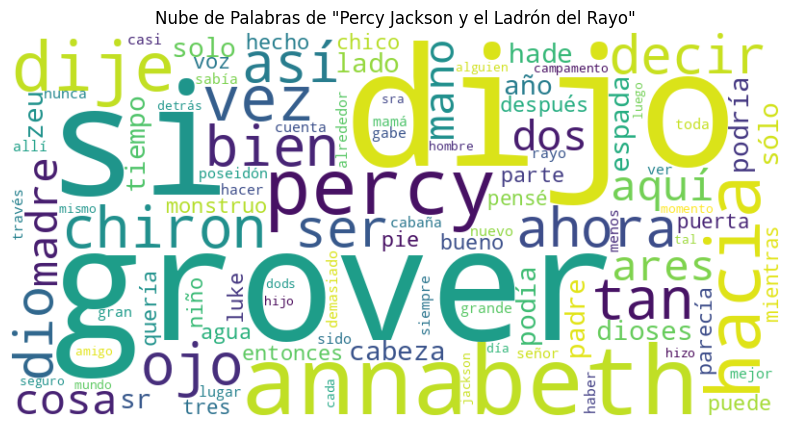

In [ ]:

!pip install wordcloud matplotlib

from wordcloud import WordCloud
import matplotlib.pyplot as plt

texto_para_nube = " ".join(filtered_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      collocations=False,
                      max_words=100,
                      contour_color='steelblue', contour_width=3).generate(texto_para_nube)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de "Percy Jackson y el Ladrón del Rayo"')
plt.show()


In [ ]:

!pip install scikit-learn tensorflow

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

segmentos = []
segmento_actual = []
for i, token in enumerate(filtered_tokens):
    segmento_actual.append(token)
    if (i + 1) % 500 == 0:
        segmentos.append(" ".join(segmento_actual))
        segmento_actual = []
if segmento_actual:
    segmentos.append(" ".join(segmento_actual))

if not segmentos:
    segmentos = [" ".join(filtered_tokens)]

print(f"\nGenerados {len(segmentos)} 'documentos' simulados para vectorización.")

vectorizador = TfidfVectorizer(max_features=5000)

X = vectorizador.fit_transform(segmentos)

print(f"Forma de la matriz TF-IDF (documentos, características/palabras): {X.shape}")

num_segmentos = len(segmentos)
y = np.array([0] * (num_segmentos // 2) + [1] * (num_segmentos - num_segmentos // 2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Datos divididos: X_train: {X_train.shape}, X_test: {X_test.shape}")


Generados 92 'documentos' simulados para vectorización.
Forma de la matriz TF-IDF (documentos, características/palabras): (92, 5000)
Datos divididos: X_train: (73, 5000), X_test: (19, 5000)


# profundizare en **NLP**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


input_dim = X_train.shape[1]

model_simplified = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_simplified.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

print("\n--- Resumen del Modelo Simplificado ---")
model_simplified.summary()

print("\n--- Entrenando el Modelo Simplificado ---")
history_simplified = model_simplified.fit(X_train.toarray(), y_train,
                                          epochs=30,
                                          batch_size=32,
                                          validation_split=0.1,
                                          verbose=1)

loss_simplified, accuracy_simplified = model_simplified.evaluate(X_test.toarray(), y_test)
print(f"\n--- Evaluación del Modelo Simplificado en el conjunto de prueba ---")
print(f"Pérdida (Loss): {loss_simplified:.4f}")
print(f"Precisión (Accuracy): {accuracy_simplified:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Resumen del Modelo Simplificado ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


--- Entrenando el Modelo Simplificado ---
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 591ms/step - accuracy: 0.4650 - loss: 0.6931 - val_accuracy: 0.7500 - val_loss: 0.6811
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6628 - loss: 0.6788 - val_accuracy: 0.7500 - val_loss: 0.6728
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8138 - loss: 0.6636 - val_accuracy: 0.7500 - val_loss: 0.6647
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9110 - loss: 0.6526 - val_accuracy: 0.8750 - val_loss: 0.6537
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9690 - loss: 0.6251 - val_accuracy: 1.0000 - val_loss: 0.6412
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9496 - loss: 0.6075 - val_accuracy: 1.0000 - val_loss: 0.6304
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9884 - loss: 0.5870 - val_accuracy: 1.0000 - val_loss: 0.6190
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.